# Camera sensor profiling with NN
### www.datosimagensonido.com
[Calibración de cámara digital con redes neuronales](https://www.datosimagensonido.com/)

## Libraries needed

In [1]:
import os
# from skimage import io  # read/write image formats (incl. 16-bit TIFF)
import imageio  # read/write image formats (incl. 16-bit TIFF)
import pickle  # to save/load model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # our MLP!

## Reading IT8 card white balanced RAW data

In [3]:
# RAW extraction with WB
# dcraw -v -r 2.299 1 1.805 1 -t 0 -o 0 -4 -T IT8.NEF

# Read image
# img = io.imread('IT8.tiff')
img = imageio.imread('IT8.tiff');

In [4]:
# Crop IT8 (6016 x 4016 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [5]:
print(type(img))
print("RGB values range from", np.min(img), "to", np.max(img))
img.shape  # 24 x 16 squares -> 22 x 12 colour patches + 22 gray patches -> total: 286 examples

<class 'imageio.core.util.Array'>
RGB values range from 614 to 49076


(2408, 3609, 3)

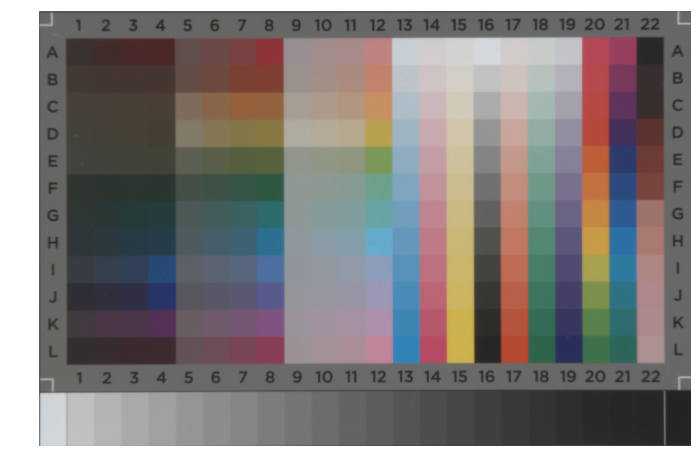

In [6]:
# Show IT8 chart
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2))
plt.axis('off');

In [7]:
# Calculate median RGB values over each patch
DeltaX = img.shape[1] / 24  # patch width
DeltaY = img.shape[0] / 16  # patch height

OSX, OSY = DeltaX/8, DeltaY/8  # safety margin

colours = np.zeros((22, 12, 3))
grays = np.zeros((22, 3))

# Read colour patches and calculate median
for x in range(22):
    for y in range(12):
        for c in [0, 1, 2]:
            X1, X2 = round((x + 1) * DeltaX + OSX), round((x + 2) * DeltaX - OSX)
            Y1, Y2 = round((y + 1) * DeltaY + OSY), round((y + 2) * DeltaY - OSY)
            colours[x, y, c] = np.median(img[Y1:Y2, X1:X2, c])         
            img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = colours[x, y, c] 

            Y1, Y2 = round(14 * DeltaY + OSY), round(16 * DeltaY - OSY)
            grays[x, c] = np.median(img[Y1:Y2, X1:X2, c])
            img[(Y1 -2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = grays[x, c]

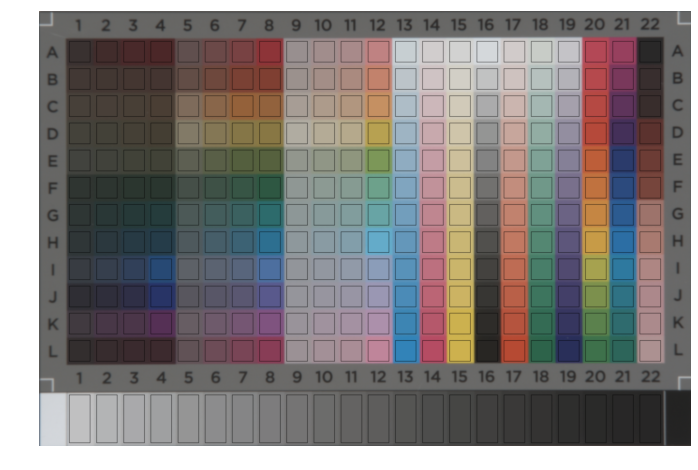

In [8]:
# Show used patches
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2), interpolation='bilinear')
plt.axis('off');

In [9]:
# Save image
# io.imsave('IT8_crop_median.tif', img)
imageio.imwrite('IT8_crop_median.tif', img)

## Reading IT8 card XYZ/Lab theoretical values